# Approximating Parameterized Advection Diffusion Equation using a Greedy Algorithm with POD

First import the necessary libraries.

In [2]:
import numpy as np
import math as m
from scipy import linalg
from scipy.sparse import diags
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

Consider the following PDE:
<br>
<br>
$$-\Delta y(x;\theta) + \begin{bmatrix} \theta \\ 0 \end{bmatrix} \nabla y(x;\theta) = 100e^{-5 \sqrt{x_1^2 + x_2^2}}, \quad (x_1, x_2) \in (-1, 1)^2,$$
<br>
with homogeneous Dirichlet boundary conditions.
<br>
<br>
Discretize using finite differences. Set the parameters as the following:
<br>
<br>
$$n_{x_1} = n_{x_2} = 30, \quad (h_1 = h_2 = 2 / 31)$$

In [3]:
nx1 = 30
nx2 = 30

h1 = 2.0 / (nx1 + 1)
h2 = 2.0 / (nx2 + 1)

x1s = np.linspace(-1 + h1, 1 - h1, nx1)
x2s = np.linspace(-1 + h2, 1 - h2, nx2)

Use upwind discretization to get the system:
<br>
<br>
$$A(\theta) y(\theta) = f$$
<br>
with
<br>
<br>
$$A(\theta) = I_{n_2} \otimes (A_1^{diff} + A_1^{conv}(\theta)) + A_2^{diff} \otimes I_{n_1} \in \mathbb{R}^{n_{x_1}n_{x_2} \times n_{x_1}n_{x_2}},$$
<br>
$$A_1^{conv}(\theta) = \frac{max(0, \theta)}{h_1} \begin{bmatrix} 1 &&&&\\ -1&1&&&\\&\ddots&\ddots&&\\&&-1&1&\\&&&-1&1 \end{bmatrix} + \frac{min(0, \theta)}{h_1} \begin{bmatrix} -1&1&&&\\ &-1&1&&\\&&\ddots&\ddots&\\&&&-1&1\\&&&&-1 \end{bmatrix} \in \mathbb{R}^{n_{x_1} \times n_{x_1}}$$
<br>
$$A_i^{diff} = \frac{1}{h_i^2} \begin{bmatrix} 2&-1&&&\\ -1&2&-1\\&\ddots&\ddots&\ddots&\\&&-1&2&-1\\&&&-1&2\end{bmatrix} \in \mathbb{R}^{n_{x_i} \times n_{x_i}}, \quad i=1,2$$
<br>
Write a function to generate $A(\theta)$ for any $\theta$:

In [4]:
def A_diff(h, nx):
    main_diag = 2 * np.ones((nx))
    offset_diag = -1 * np.ones((nx - 1))
    return (1 / h**2) * diags([offset_diag, main_diag, offset_diag], [-1, 0, 1]).toarray()

A1_diff = A_diff(h1, nx1)
A2_diff = A_diff(h2, nx2)

A0 = np.kron(np.eye(nx2), A1_diff) + np.kron(A2_diff, np.eye(nx1))
A1 = np.kron(np.eye(nx2),(1 / h1) * diags([-1 * np.ones((nx1 - 1)), np.ones((nx1))], [-1, 0]).toarray())
A2 = np.kron(np.eye(nx2),(1 / h1) * diags([-1 * np.ones((nx1)), np.ones((nx1 - 1))], [0, 1]).toarray())


def A_theta(theta):
    return A0 + max(0, theta) * A1 + min(0, theta) * A2

Generate the array $f$:

In [5]:
def f_func(x1, x2):
    return 100 * m.exp(-5 * m.sqrt(x1**2 + x2**2))

f_idx = 0
f = np.zeros((nx1 * nx2))

for x2 in x2s:
    for x1 in x1s:
        f[f_idx] = f_func(x1, x2)
        f_idx += 1

Find a matrix $V$ where $y(\theta)$ is approximately in $R(V) \quad \forall \theta \in [-10, 10]$. Implement greedy algorithm to compute $V$:
<br>

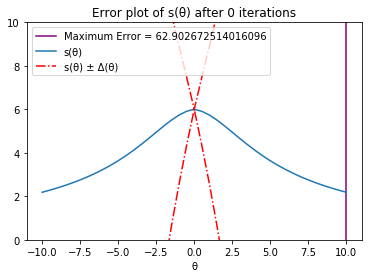

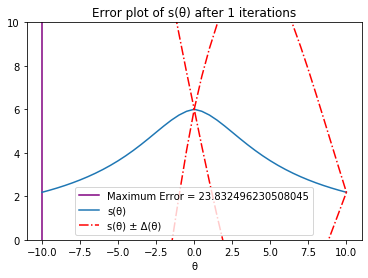

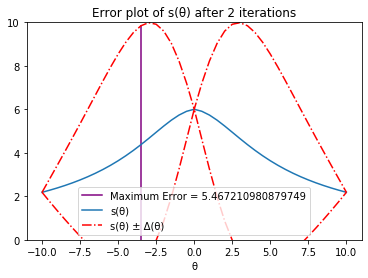

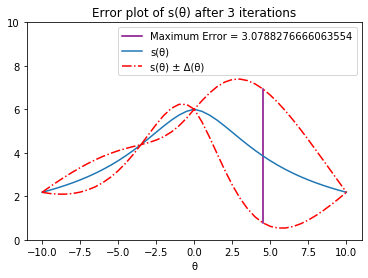

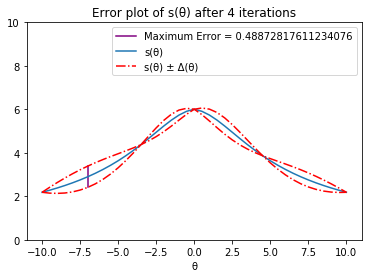

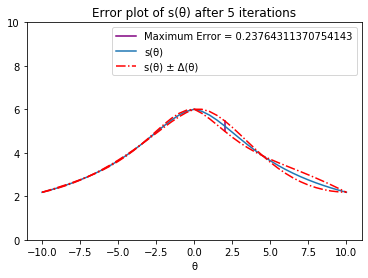

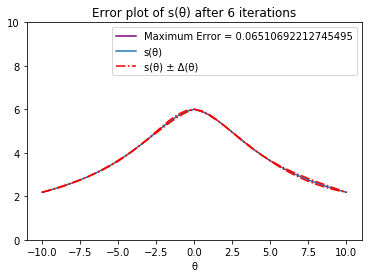

Terminated on iteration number: 6


In [6]:
thetas_train = np.linspace(-10, 10, 41).tolist()
tolerance = 0.1

l = h1 * h2 * np.ones((nx1 * nx2, 1))

As = np.zeros((len(thetas_train), nx1 * nx2, nx1 * nx2))
for idx in range(len(thetas_train)):
    As[idx,:,:] = A_theta(thetas_train[idx])

norms = []
for A in As:
    norms.append(linalg.norm(linalg.inv(A)))
alpha = max(norms)

def delta(A_theta, V):
    Vt = np.transpose(V)
    At = np.transpose(A_theta)
    A_hat_theta = Vt @ A_theta @ V
    y_hat = linalg.solve(A_hat_theta, Vt @ f)
    p_hat = linalg.solve(np.transpose(A_hat_theta), Vt @ l)
    
    return alpha * linalg.norm(f - A_theta @ V @ y_hat) * linalg.norm(l - At @ V @ p_hat)

def solve_fd(theta_idx):
    return linalg.solve(As[theta_idx,:,:], f)

def rom_error(V, theta_idx): 
    return delta(As[theta_idx,:,:], V)

V = np.reshape(solve_fd(thetas_train.index(0)), (nx1 * nx2, 1))

thetas_remaining = thetas_train.copy()
thetas_remaining.remove(0)

S = []
for idx in range(len(thetas_train)):
    S.append(np.dot(l.reshape((nx1 * nx2)), solve_fd(idx)))
    
for iter in range(len(thetas_train) - 1):
        
    ####################
    #Plots
    
    S_perror = []
    S_merror = []
    for idx in range(len(thetas_train)):
        if thetas_train[idx] in thetas_remaining: 
            error = rom_error(V, idx)
            S_merror.append(S[idx] - error) 
            S_perror.append(S[idx] + error)
        else:
            S_merror.append(S[idx]) 
            S_perror.append(S[idx])

    fig = plt.figure()
    max_error_idx = np.argmax(np.asarray([a - b for a, b in zip(S_perror, S_merror)]))
    plt.plot([thetas_train[max_error_idx]] * 2, [S_merror[max_error_idx], S_perror[max_error_idx]],
             color = 'purple', 
             label = f'Maximum Error = {(S_perror[max_error_idx] - S_merror[max_error_idx]) / 2}')
    plt.plot(thetas_train, S, label = 's(\u03B8)')
    plt.plot(thetas_train, S_merror, color = 'red', label='s(\u03B8) \u00B1 \u0394(\u03B8)',
             linestyle = '-.')
    plt.plot(thetas_train, S_perror, color='red', linestyle = '-.')
    plt.ylim((0, 10))
    plt.xlabel('\u03B8')
    plt.title(f'Error plot of s(\u03B8) after {iter} iterations')
    plt.legend()
    plt.show()
    ####################    
    
    if  (S_perror[max_error_idx] - S_merror[max_error_idx]) / 2 < tolerance:
        print ("Terminated on iteration number: " + str(iter))
        break
        
    else:
        V_new = np.zeros((nx1 * nx2, V.shape[1] + 1))
        V_new[:, :-1] = V
        V_new[:, -1] = solve_fd(max_error_idx)
        V = linalg.orth(V_new)
    
    if iter == len(thetas_train) - 2:
        print ("Maximum number of iterations reached")

Compute the POD and FD solution for values of $\theta \notin R(V)$:

In [6]:
A0hat = np.transpose(V) @ A0 @ V
A1hat = np.transpose(V) @ A1 @ V
A2hat = np.transpose(V) @ A2 @ V

def Ahat(theta):
    return A0hat + max(0, theta) * A1hat + min(0, theta) * A2hat

fhat = np.transpose(V) @ f

Y_fd_snap_plot = np.zeros((nx1 * nx2, len(thetas_remaining)))
Y_pod_snap_plot = np.zeros((nx1 * nx2, len(thetas_remaining)))

for idx in range(len(thetas_remaining)):
    Y_fd_snap_plot[:,idx] = linalg.solve(As[thetas_train.index(thetas_remaining[idx])], f)
    Y_pod_snap_plot[:,idx] = V @ linalg.solve(Ahat(thetas_remaining[idx]), fhat)

Observe the error between the POD and FD approximations.

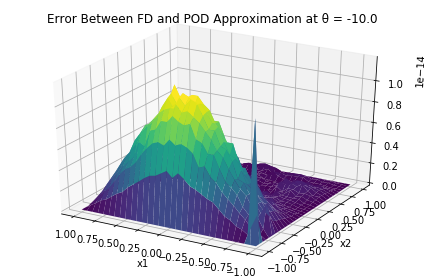

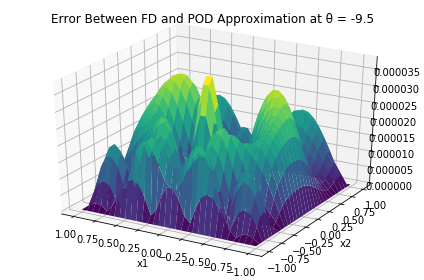

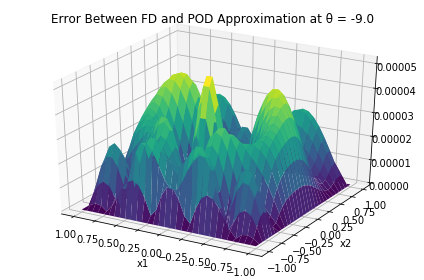

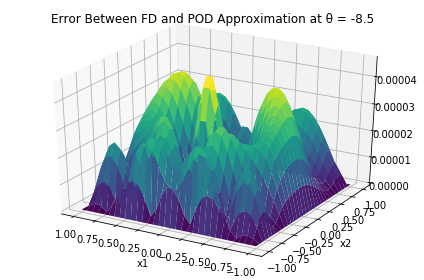

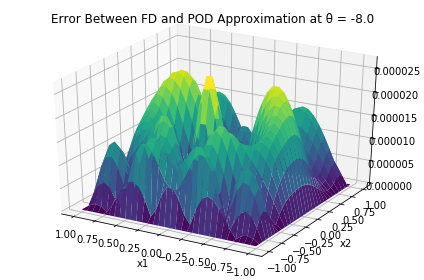

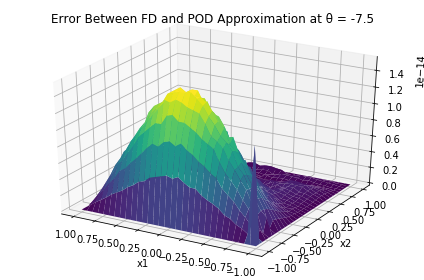

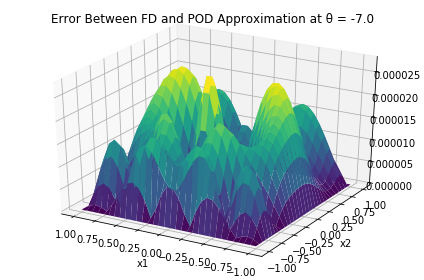

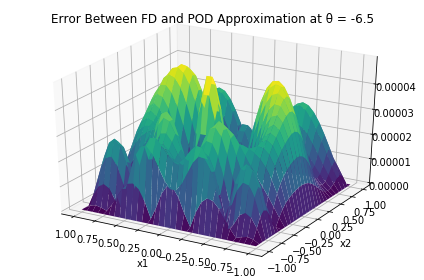

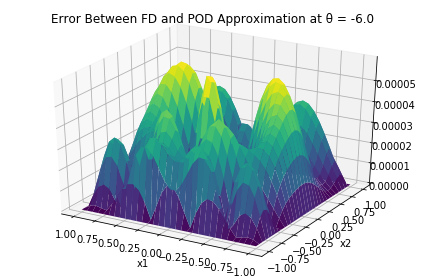

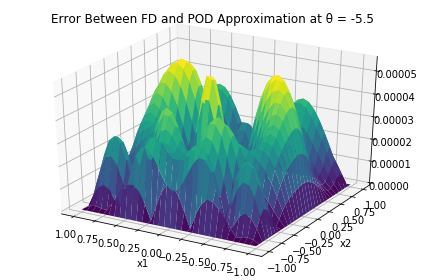

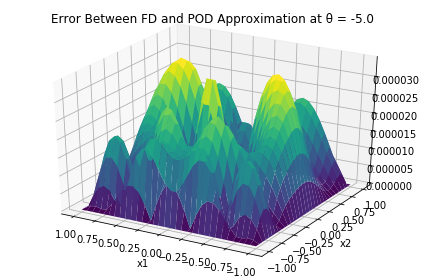

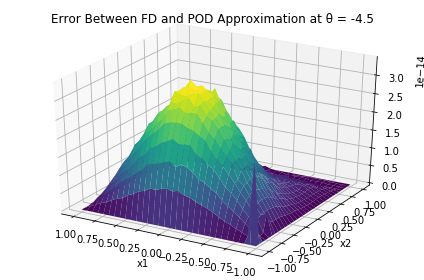

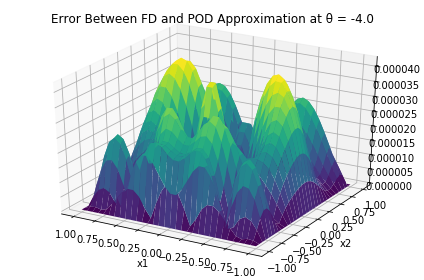

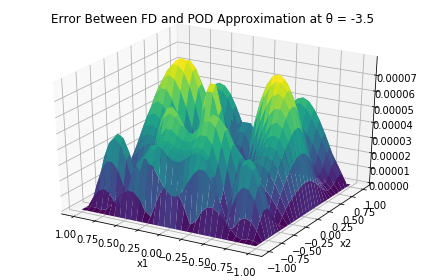

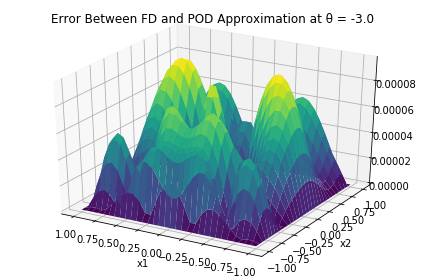

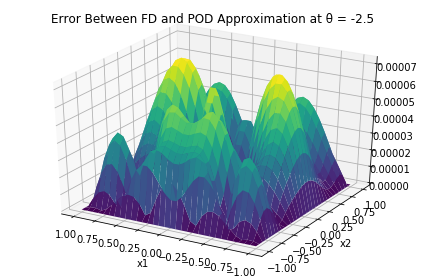

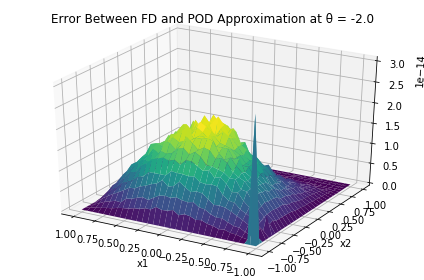

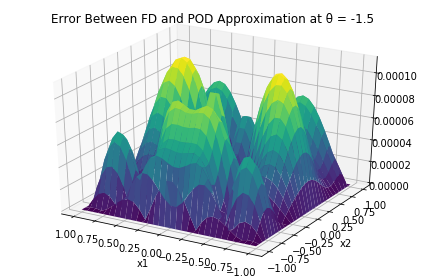

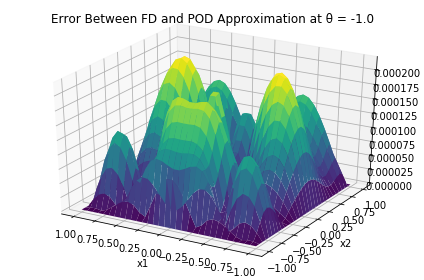

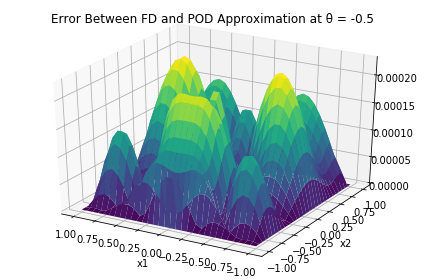

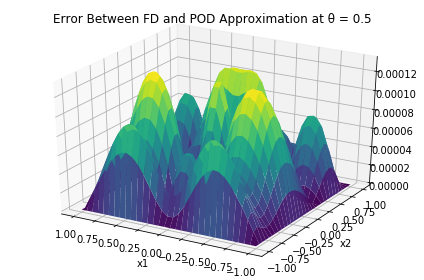

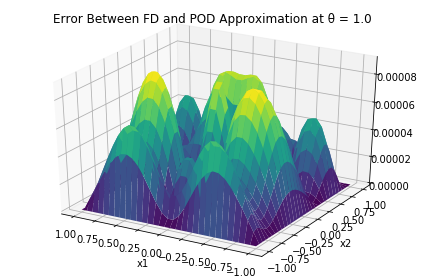

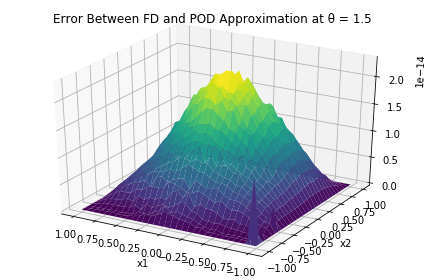

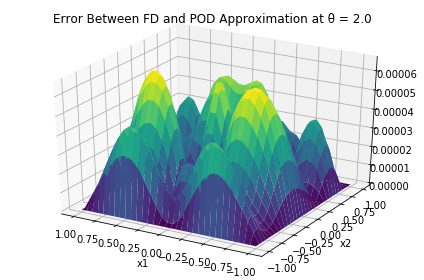

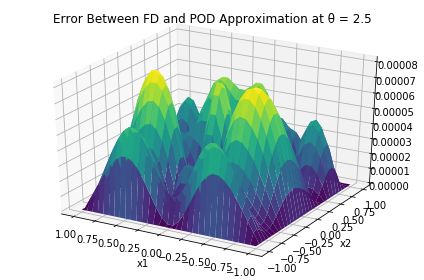

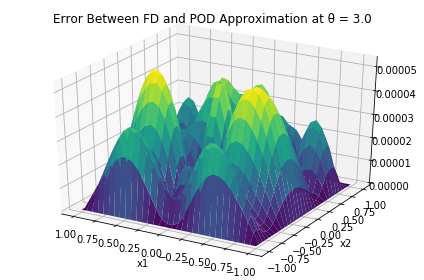

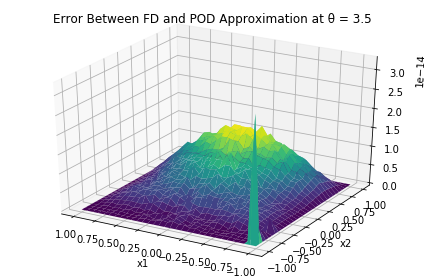

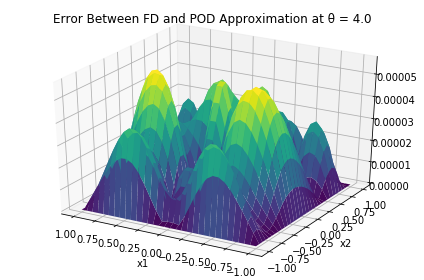

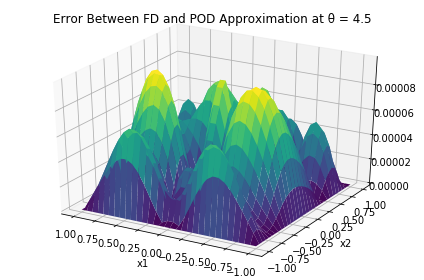

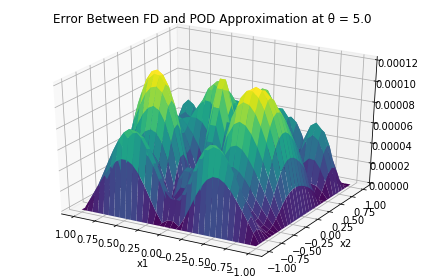

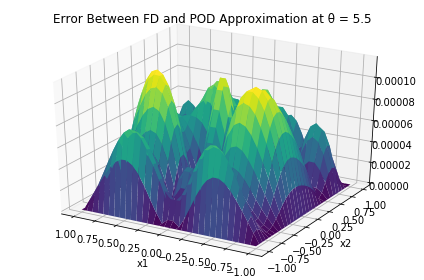

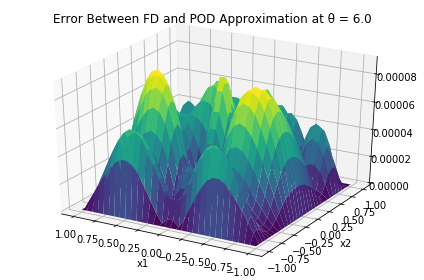

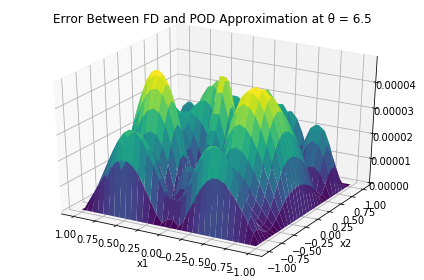

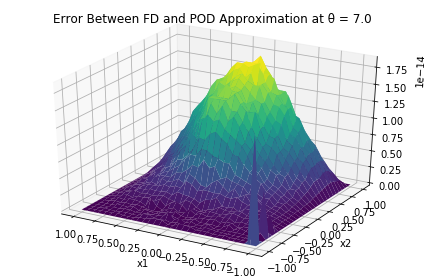

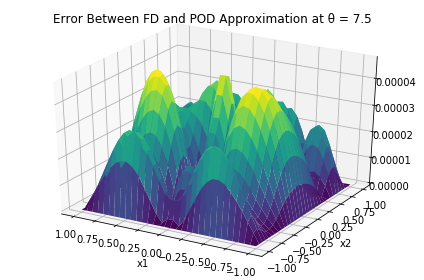

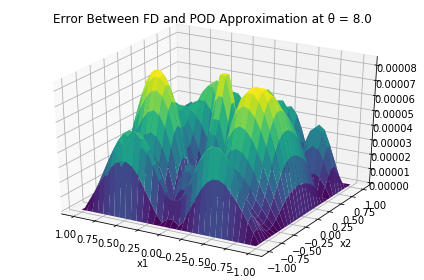

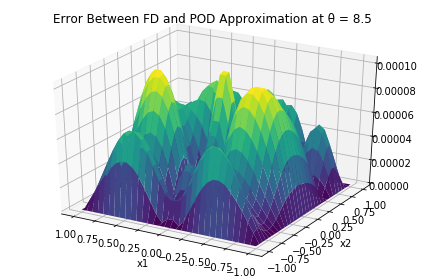

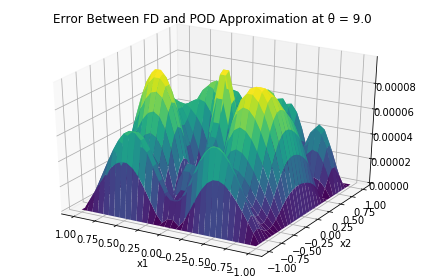

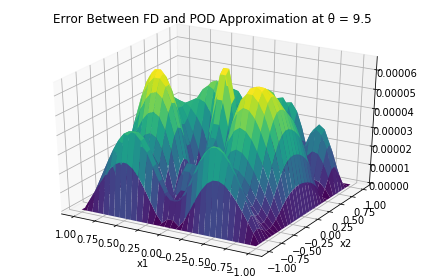

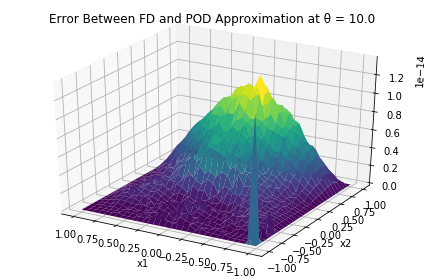

In [12]:
def plot_at_thetas(thetas, snaps, title):
    for snap_idx in range(len(thetas)):
        fig = plt.figure()
        yplot = np.zeros((nx1 + 2, nx2 + 2))
        yplot[1:-1, 1:-1] = np.reshape(snaps[:,snap_idx],(nx1, nx2))
    
        [X1,X2]= np.meshgrid(np.linspace(-1, 1, nx1 + 2), np.linspace(-1, 1, nx2 + 2))
        ax = plt.axes(projection='3d')
        ax.plot_surface(X1, X2, np.transpose(yplot), rstride=1, cstride=1,cmap='viridis',edgecolor='none')
        ax.invert_xaxis()
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.title(title + ' at \u03B8 = ' + str(thetas[snap_idx]))
        plt.tight_layout()   
        plt.show()

plot_at_thetas(thetas_remaining, abs(Y_pod_snap_plot - Y_fd_snap_plot), 
               "Error Between FD and POD Approximation") 